<div><img style="float: right; width: 120px; vertical-align:rigth" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />



<h1><center>Standford Car Dataset</center></h1>

<center>Proyecto de Ciencia de Datos</center>
<center>Grado en Ciencia de Datos e Inteligencia Artificial</center>
<center>Escuela Técnica Superior de Ingeniería de Sistemas Informáticos</center>
<center>2023-2024</center>



En este proyecto se va a trabajar con el dataset de [Stanford Car Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset) de [Kaggle](https://www.kaggle.com/) que contiene 16.185 imágenes de 196 clases de coches. El dataset está dividido en 8.144 imágenes de entrenamiento y 8.041 imágenes de test. 

En específico, se ha optado por trabajar con el dataset de [Stanford Car Dataset by classes folder](https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder) que contiene las imágenes de los coches divididas en carpetas por clases *(y las clases del dataset original no están correctamente etiquetadas)*.

<span style="color:orange">**NOTA**</span>: Se recomienda el uso de GPU para la ejecución de este notebook si se desea entrenar los modelos de redes neuronales. No obstante, para una mayor facilidad de uso, se ha optado por entrenar los modelos y posteriormente guardarlos en la carpeta `models` para su posterior uso.

Dado que se está haciendo uso de GPU en Windows mediante [WSL2](https://docs.microsoft.com/en-us/windows/wsl/about) y [CUDA](https://developer.nvidia.com/cuda-zone), la siguiente celda nos permite evitar ciertos <span style="color:red">warnings</span> que aparecen al ejecutar el notebook pero que no afectan al funcionamiento del mismo.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Import Libraries


In [2]:
# Obtain current working directory
os.chdir('..')

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Variables containing the paths
from settings import settings

# Auxiliar functions for data processing and visualization
from auxiliar_functions.img_generator import  create_img_generator
from auxiliar_functions.plot_functions import plot_evaluation, plot_comparison, plot_imgs_from_generator, plot_samples

# Call the models from scratch
from models.vgg_16 import VGG16
from models.lenet import LeNet
from models.alexnet import AlexNet
from models.resnet import ResNet
from models.googlenet import GoogleNet

### Check GPU Availability

Las siguientes 3 celdas nos permiten comprobar si tenemos GPU disponible para su uso en el notebook.

In [4]:
# Check if GPU is running
print(len(tf.config.list_physical_devices('GPU')) > 0)

# See GPU devices in use
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

# Set memory growth to True. This will allow to allocate memory as needed
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load and Visualize the Dataset

A continuación, se cargan las imágenes del dataset y se visualizan algunas de ellas. Todos los directorios que se van a utilizar en este repositorio se van a almacenar en la <span style="color:#20B2AA">**settings.py**</span> para su fácil acceso.

In [5]:
# Get train and test paths
train_path, test_path = settings.train, settings.test

# Load train and test data
train = pd.read_csv(settings.data_train, header=None)
test = pd.read_csv(settings.data_test, header=None)
train.shape, test.shape

((8144, 6), (8041, 6))

El archivo <span style="color:#20B2AA">**names.csv**</span> contiene los 196 nombres de las clases de coches que se van a utilizar en este proyecto. Se requiere un pequeño preprocesamiento para sustituir $/$ por $-$ dado que posteriormente se van a utilizar como nombres de carpetas y los $/$ ocasionan problemas.

In [6]:
# Load model names
model_names = pd.read_csv(settings.car_model, header=None)[0].tolist()

# Correct model names for them to be turned into folder name
model_names = [name.replace('/', '-') for name in model_names]

print(len(model_names), '\n', model_names[:5])

196 
 ['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012']


In [7]:
train.head()

0    1    2     3     4    5
0  00001.jpg   39  116   569   375   14
1  00002.jpg   36  116   868   587    3
2  00003.jpg   85  109   601   381   91
3  00004.jpg  621  393  1484  1096  134
4  00005.jpg   14   36   133    99  106

El dataset contiene las siguientes columnas:

- La columna 0 contiene el nombre de la imagen dentro de cada carpeta.
- La columna 1 hace referencia a la coordenada `x` del punto superior izquierdo del cuadro delimitador.
- La columna 2 hace referencia a la coordenada `y` del punto superior izquierdo del cuadro delimitador.
- La columna 3 hace referencia a la coordenada `x` del punto inferior derecho del cuadro delimitador.
- La columna 4 hace referencia a la coordenada `y` del punto inferior derecho del cuadro delimitador.
- La columna 5 hace referencia a la clase del coche.

Mediante el archivo que contiene los diferentes modelos y la columna 5 del dataset, se obtiene el nombre de la clase del coche al que pertenece cada imagen.

<span style="color:orange">**NOTA**</span>: Dado que el carácter $/$ ocasiona problemas en el nombre de las carpetas, se ha optado por sustituirlo por $-$, que es la manera en la que se nomrbra a las carpetas con cada modelo.

In [8]:
# Change Column Names
train.columns = test.columns = ['img_name', 'x', 'y', 'width', 'height', 'label']
test.columns = ['img_name', 'x', 'y', 'width', 'height', 'label']

# For each item in df, find the corresponding model name
train['model'] = train.label.apply(lambda x: model_names[x-1])
test['model'] = test.label.apply(lambda x: model_names[x-1])

# Correct model names for them to be turned into folder name
train['model'] = train.model.apply(lambda x: x.replace('/', '-'))
test['model'] = test.model.apply(lambda x: x.replace('/', '-'))

In [9]:
train.head()

img_name    x    y  width  height  label  \
0  00001.jpg   39  116    569     375     14   
1  00002.jpg   36  116    868     587      3   
2  00003.jpg   85  109    601     381     91   
3  00004.jpg  621  393   1484    1096    134   
4  00005.jpg   14   36    133      99    106   

                                 model  
0                  Audi TTS Coupe 2012  
1                  Acura TL Sedan 2012  
2           Dodge Dakota Club Cab 2007  
3     Hyundai Sonata Hybrid Sedan 2012  
4  Ford F-450 Super Duty Crew Cab 2012

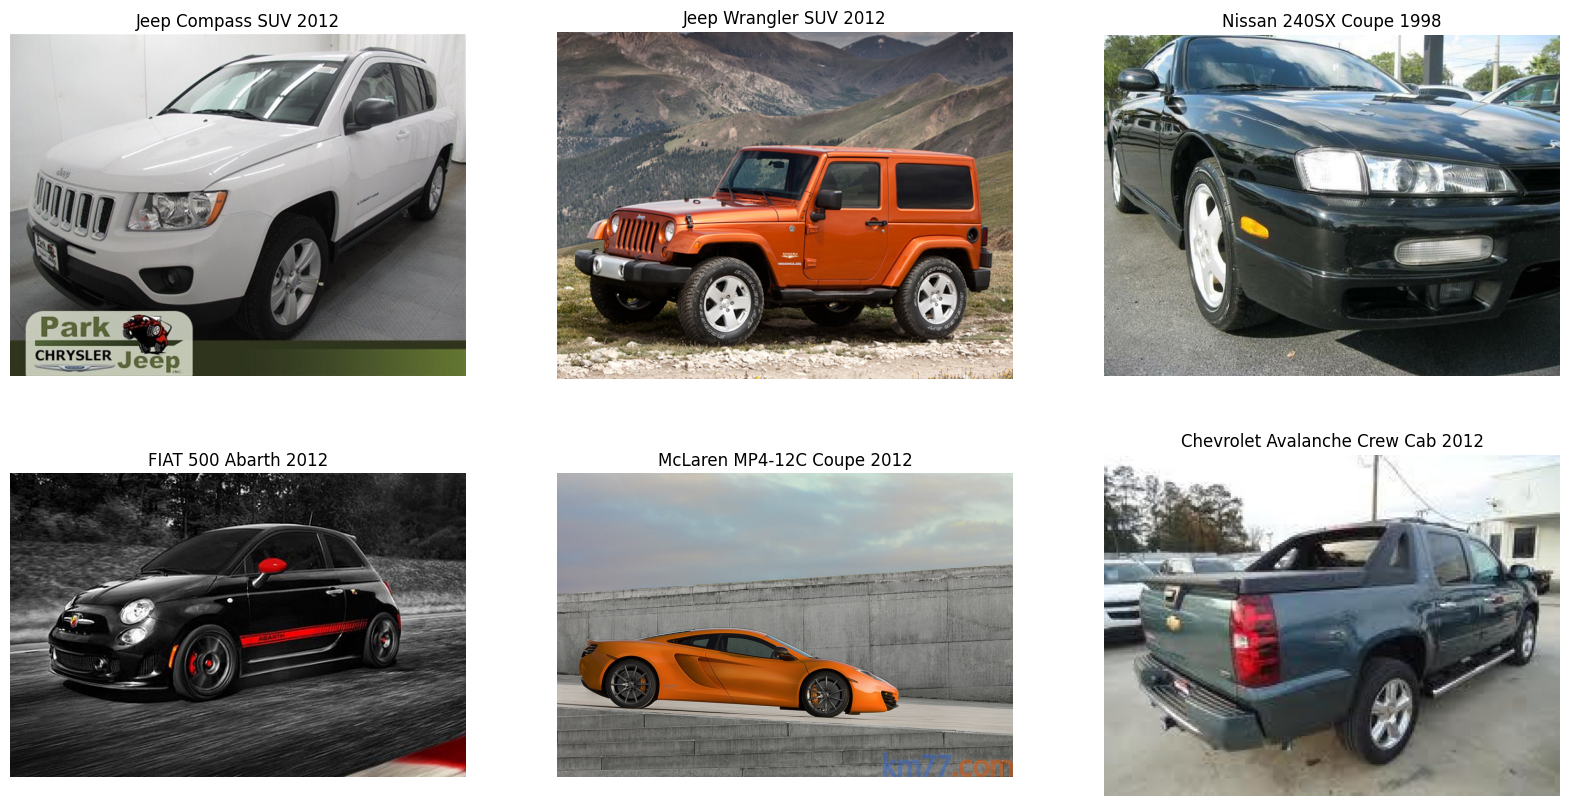

In [10]:
plot_samples(train)

In [11]:
# Check Image Sizes
sample_img = plt.imread(settings.train + train['model'][0] + '/00001.jpg')
print(f'Las dimensiones de la imagen son: {sample_img.shape}')

Las dimensiones de la imagen son: (400, 600, 3)


## Data Preprocessing

Dado que en este notebook va a implementar todos los modelos CNN vistos en clase, se va a realizar un preprocesamiento de los datos para que se ajusten a las necesidades de cada modelo. Para ello, se hará uso de la función ``ImageDataGenerator`` y de la función ``flow_from_directory``. Ambas funciones han sido recogidas en una función personalizada llamada ``create_img_generator``.

- ``ImageDataGenerator``: Esta función nos permite generar un flujo de datos a partir de las imágenes que se encuentran en un directorio. El preprocesamiento que se va a realizar es el siguiente:
    - ``rescale``: Se va a reescalar cada imagen dividiendo cada pixel por 255.
    - ``rotation_range``: Se va a rotar cada imagen 20 grados.
    - ``width_shift_range``: Se va a desplazar cada imagen horizontalmente un 20% de su ancho.
    - ``height_shift_range``: Se va a desplazar cada imagen verticalmente un 20% de su altura.
    - ``horizontal_flip``: Se va a voltear cada imagen horizontalmente.
    - ``zoom_range``: Se va a hacer zoom a cada imagen 20%.
    - ``fill_mode``: Se va a rellenar el espacio que queda vacío al rotar o desplazar cada imagen con el valor más cercano.
    - ``validation_split``: Se va a dividir el dataset en un 80% para entrenamiento y un 20% para validación.

- ``flow_from_directory``: Esta función nos permite generar un flujo de datos a partir de las imágenes que se encuentran en un directorio. Una de las mayores ventajas es que la función supone que las imágenes se encuentran en carpetas separadas por clases, por lo que no es necesario especificar las etiquetas de cada imagen.

In [12]:
num_classes = len(model_names)

# Target Sizes
TARGET_SIZE_227 = (227, 227)
TARGET_SIZE_224 = (224, 224)
TARGET_SIZE_64 = (64, 64)
TARGET_SIZE_32 = (32, 32)

# Batch Sizes
BATCH_SIZE = 128
BATCH_SIZE_64 = 64
BATCH_SIZE_32 = 32
BATCH_SIZE_16 = 16
BATCH_SIZE_8 = 8


# Create Image Generators with different target sizes and batch sizes
train_gen_227, test_gen_227, val_gen_227 = create_img_generator(
    train_path=train_path,
    test_path=test_path,
    target_size=TARGET_SIZE_227)

train_gen_224, test_gen_224, val_gen_224 = create_img_generator(
    train_path=train_path,
    test_path=test_path,
    target_size=TARGET_SIZE_224)

train_gen_64, test_gen_64, val_gen_64 = create_img_generator(
    train_path=train_path,
    test_path=test_path,
    target_size=TARGET_SIZE_64)

train_gen_32, test_gen_32, val_gen_32 = create_img_generator(
    train_path=train_path,
    test_path=test_path,
    target_size=TARGET_SIZE_32)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.



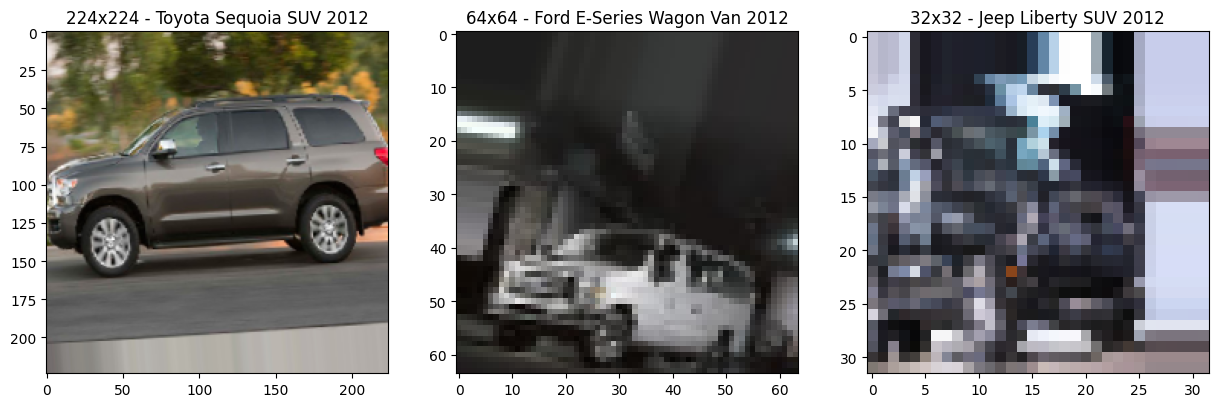

In [13]:
train_generators = {'224': train_gen_224,
                    '64': train_gen_64,
                    '32': train_gen_32}

plot_imgs_from_generator(train_generators, ncols=len(train_generators))

## CNN Models (*Convolutional Neural Network*) 

### LeNet Model


<img src="../images/lenet5.png" style="width: 75%;"/>


El modelo **LeNet** es una de las primeras redes neuronales convolucionales que se crearon. Fue creada por Yann LeCun en 1998 y fue diseñada para reconocer dígitos escritos a mano. El modelo LeNet se compone de 7 capas una capa de entrada, 4 capas convolucionales y 2 capas densas. La capa de entrada recibe una imagen de 32x32 píxeles. Las 4 capas convolucionales se encargan de extraer las características de la imagen. Las 2 capas densas se encargan de clasificar las características extraídas por las capas convolucionales. Hace uso de la función de activación **tahn** en las capas convolucionales y de la función de activación **softmax** en la capa de salida.

Dado que **LeNet** es un modelo simple y específico para reconocer dígitos escritos a mano, se ha optado por reducir el número de clases de coches a 10 y observar el comportamiento del modelo.

In [13]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [14]:
# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
# Create LeNet model
ln = LeNet(input_shape=TARGET_SIZE_32 + (1,), num_classes=num_classes, see_summary=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120 

In [17]:
# Train the model
ln_history = ln.train(train_generator=train_gen_32, validation_generator=val_gen_32, epochs=30, verbose=1, patience=4)

Model not found
Training model...
Epoch 1/30
207/207 [==============================] - ETA: 0s - loss: 5.2811 - accuracy: 0.0053
Epoch 1: val_loss improved from inf to 5.26437, saving model to models/checkpoints/lenet
INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


207/207 [==============================] - 79s 369ms/step - loss: 5.2811 - accuracy: 0.0053 - val_loss: 5.2644 - val_accuracy: 0.0084
Epoch 2/30
207/207 [==============================] - ETA: 0s - loss: 5.2642 - accuracy: 0.0077
Epoch 2: val_loss improved from 5.26437 to 5.25382, saving model to models/checkpoints/lenet
INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


207/207 [==============================] - 74s 357ms/step - loss: 5.2642 - accuracy: 0.0077 - val_loss: 5.2538 - val_accuracy: 0.0097
Epoch 3/30
207/207 [==============================] - ETA: 0s - loss: 5.2326 - accuracy: 0.0100
Epoch 3: val_loss improved from 5.25382 to 5.20468, saving model to models/checkpoints/lenet
INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


207/207 [==============================] - 69s 335ms/step - loss: 5.2326 - accuracy: 0.0100 - val_loss: 5.2047 - val_accuracy: 0.0220
Epoch 4/30
207/207 [==============================] - ETA: 0s - loss: 5.1691 - accuracy: 0.0145
Epoch 4: val_loss improved from 5.20468 to 5.16932, saving model to models/checkpoints/lenet
INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


207/207 [==============================] - 68s 330ms/step - loss: 5.1691 - accuracy: 0.0145 - val_loss: 5.1693 - val_accuracy: 0.0175
Epoch 5/30
207/207 [==============================] - ETA: 0s - loss: 5.1439 - accuracy: 0.0179
Epoch 5: val_loss improved from 5.16932 to 5.15905, saving model to models/checkpoints/lenet
INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


207/207 [==============================] - 74s 357ms/step - loss: 5.1439 - accuracy: 0.0179 - val_loss: 5.1591 - val_accuracy: 0.0155
Epoch 6/30
207/207 [==============================] - ETA: 0s - loss: 5.1196 - accuracy: 0.0191
Epoch 6: val_loss did not improve from 5.15905
207/207 [==============================] - 95s 457ms/step - loss: 5.1196 - accuracy: 0.0191 - val_loss: 5.1671 - val_accuracy: 0.0181
Epoch 7/30
207/207 [==============================] - ETA: 0s - loss: 5.1034 - accuracy: 0.0230
Epoch 7: val_loss did not improve from 5.15905
207/207 [==============================] - 95s 458ms/step - loss: 5.1034 - accuracy: 0.0230 - val_loss: 5.1594 - val_accuracy: 0.0226
Epoch 8/30
207/207 [==============================] - ETA: 0s - loss: 5.0888 - accuracy: 0.0235
Epoch 8: val_loss improved from 5.15905 to 5.14611, saving model to models/checkpoints/lenet
INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


207/207 [==============================] - 103s 500ms/step - loss: 5.0888 - accuracy: 0.0235 - val_loss: 5.1461 - val_accuracy: 0.0201
Epoch 9/30
207/207 [==============================] - ETA: 0s - loss: 5.0589 - accuracy: 0.0258
Epoch 9: val_loss improved from 5.14611 to 5.12087, saving model to models/checkpoints/lenet
INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


207/207 [==============================] - 75s 365ms/step - loss: 5.0589 - accuracy: 0.0258 - val_loss: 5.1209 - val_accuracy: 0.0239
Epoch 10/30
207/207 [==============================] - ETA: 0s - loss: 5.0563 - accuracy: 0.0209
Epoch 10: val_loss did not improve from 5.12087
207/207 [==============================] - 117s 567ms/step - loss: 5.0563 - accuracy: 0.0209 - val_loss: 5.1349 - val_accuracy: 0.0207
Epoch 11/30
207/207 [==============================] - ETA: 0s - loss: 5.0570 - accuracy: 0.0259
Epoch 11: val_loss did not improve from 5.12087
207/207 [==============================] - 130s 628ms/step - loss: 5.0570 - accuracy: 0.0259 - val_loss: 5.1414 - val_accuracy: 0.0220
Epoch 12/30
207/207 [==============================] - ETA: 0s - loss: 5.0422 - accuracy: 0.0262
Epoch 12: val_loss did not improve from 5.12087
207/207 [==============================] - 136s 658ms/step - loss: 5.0422 - accuracy: 0.0262 - val_loss: 5.1288 - val_accuracy: 0.0213
Epoch 13/30
207/207 [=====

INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


Restoring model weights from the end of the best epoch: 9.
207/207 [==============================] - 123s 592ms/step - loss: 5.0245 - accuracy: 0.0271 - val_loss: 5.0872 - val_accuracy: 0.0226
Epoch 13: early stopping
Model and history saved


252/252 [==============================] - 87s 343ms/step - loss: 5.0620 - accuracy: 0.0298
Loss: 5.06
Accuracy: 2.98%


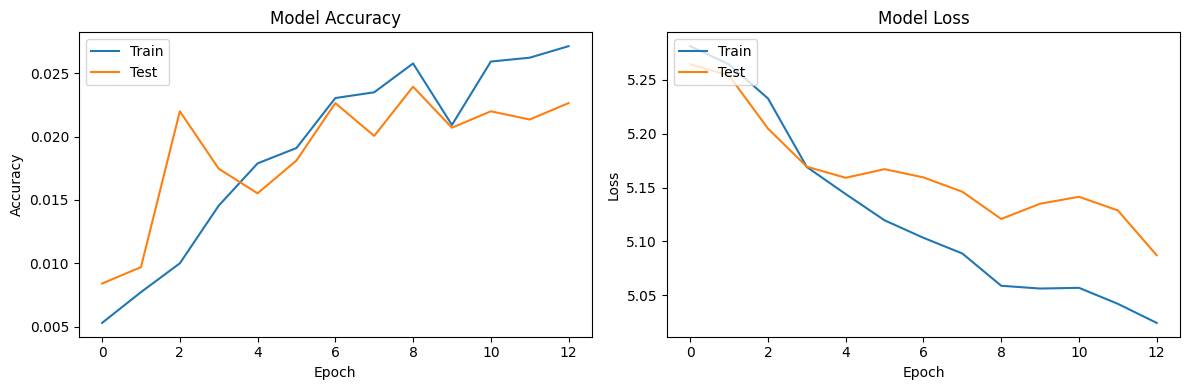

In [18]:
# Evaluate the model
ln_loss, ln_acc = ln.evaluate(test_gen_32)
plot_evaluation(history=ln_history)

252/252 [==============================] - 90s 356ms/step


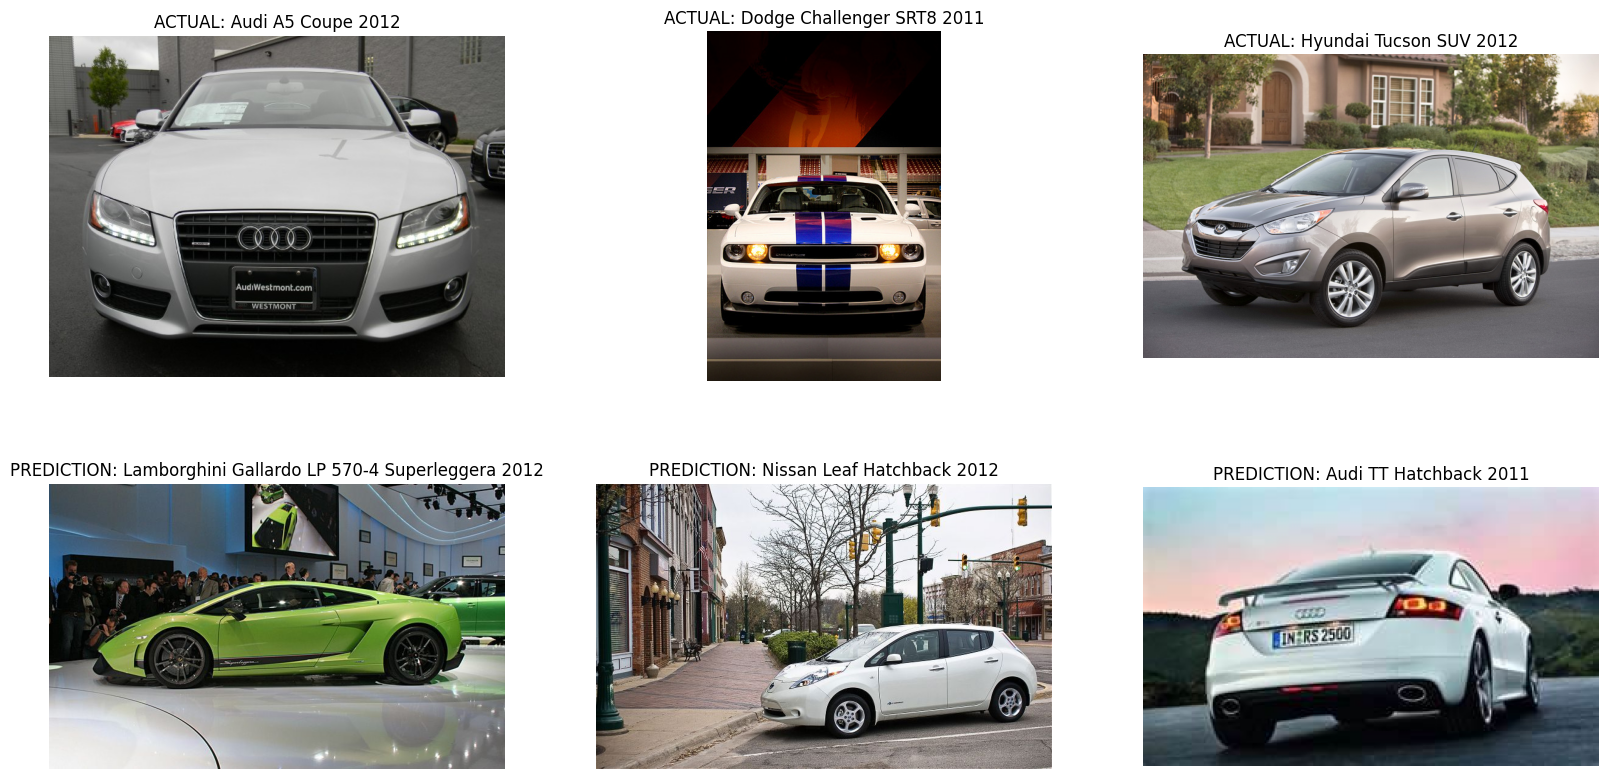

In [19]:
# Predictions
ln_prediction = ln.predict(test_gen_32)   
plot_comparison(df_test=test, model_names=model_names, predicted_classes=ln_prediction)

### AlexNet Model

<img src="../images/alexnet.png" style="width: 75%;"/>

AlexNet es una red neuronal convolucional profunda que fue creada por Alex Krizhevsky, Ilya Sutskever y Geoffrey Hinton en 2012. Fue la primera red neuronal convolucional en ganar el concurso ImageNet Large Scale Visual Recognition Challenge (ILSVRC) en 2012. El modelo AlexNet se compone de 8 capas una capa de entrada, 5 capas convolucionales y 3 capas densas. La capa de entrada recibe una imagen de 227x227 píxeles. La entrada del modelo es una imagen RGB de 227x227x3. Hace uso de la función de activación **ReLU** en las capas convolucionales y de la función de activación **softmax** en la capa de salida.

In [20]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [21]:
# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
# Create AlexNet model
an = AlexNet(input_shape=TARGET_SIZE_227 + (3,), num_classes=num_classes, see_summary=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120

In [23]:
# Train the model
an_history = an.train(train_generator=train_gen_227, validation_generator=val_gen_227, patience=4, verbose=1)

Model not found
Training model...
Epoch 1/100
207/207 [==============================] - ETA: 0s - loss: 5.2999 - accuracy: 0.0059
Epoch 1: val_loss improved from inf to 5.27679, saving model to models/checkpoints/alexnet
INFO:tensorflow:Assets written to: models/checkpoints/alexnet/assets


INFO:tensorflow:Assets written to: models/checkpoints/alexnet/assets


207/207 [==============================] - 131s 613ms/step - loss: 5.2999 - accuracy: 0.0059 - val_loss: 5.2768 - val_accuracy: 0.0084
Epoch 2/100
207/207 [==============================] - ETA: 0s - loss: 5.2783 - accuracy: 0.0083
Epoch 2: val_loss improved from 5.27679 to 5.27565, saving model to models/checkpoints/alexnet
INFO:tensorflow:Assets written to: models/checkpoints/alexnet/assets


INFO:tensorflow:Assets written to: models/checkpoints/alexnet/assets


207/207 [==============================] - 117s 566ms/step - loss: 5.2783 - accuracy: 0.0083 - val_loss: 5.2756 - val_accuracy: 0.0084
Epoch 3/100
207/207 [==============================] - ETA: 0s - loss: 5.2774 - accuracy: 0.0083
Epoch 3: val_loss improved from 5.27565 to 5.27477, saving model to models/checkpoints/alexnet
INFO:tensorflow:Assets written to: models/checkpoints/alexnet/assets


INFO:tensorflow:Assets written to: models/checkpoints/alexnet/assets


207/207 [==============================] - 115s 554ms/step - loss: 5.2774 - accuracy: 0.0083 - val_loss: 5.2748 - val_accuracy: 0.0084
Epoch 4/100
207/207 [==============================] - ETA: 0s - loss: 5.2769 - accuracy: 0.0083
Epoch 4: val_loss improved from 5.27477 to 5.27401, saving model to models/checkpoints/alexnet
INFO:tensorflow:Assets written to: models/checkpoints/alexnet/assets


INFO:tensorflow:Assets written to: models/checkpoints/alexnet/assets


207/207 [==============================] - 118s 569ms/step - loss: 5.2769 - accuracy: 0.0083 - val_loss: 5.2740 - val_accuracy: 0.0084
Epoch 5/100
207/207 [==============================] - ETA: 0s - loss: 5.2764 - accuracy: 0.0083
Epoch 5: val_loss improved from 5.27401 to 5.27360, saving model to models/checkpoints/alexnet
INFO:tensorflow:Assets written to: models/checkpoints/alexnet/assets


INFO:tensorflow:Assets written to: models/checkpoints/alexnet/assets


Restoring model weights from the end of the best epoch: 1.
207/207 [==============================] - 113s 544ms/step - loss: 5.2764 - accuracy: 0.0083 - val_loss: 5.2736 - val_accuracy: 0.0084
Epoch 5: early stopping
Model and history saved


207/207 [==============================] - 93s 448ms/step - loss: 5.2740 - accuracy: 0.0083
Loss: 5.27
Accuracy: 0.83%


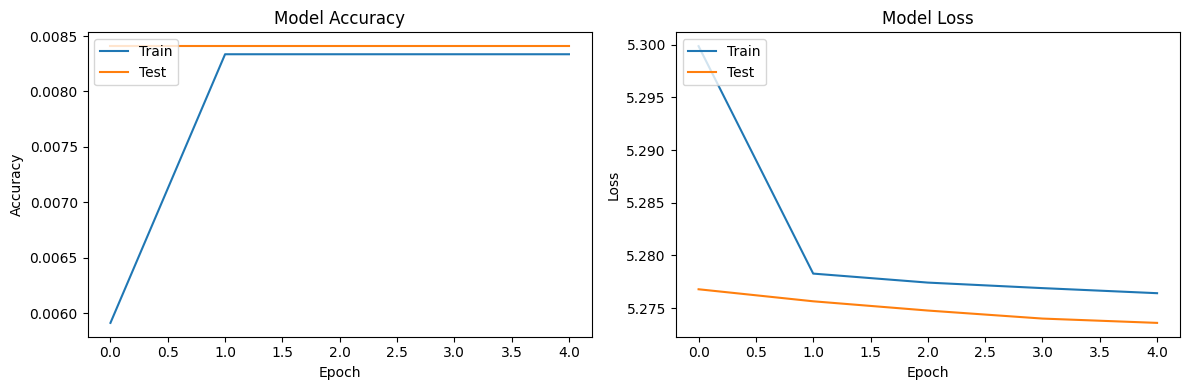

In [29]:
# Evaluate the model
an_loss, an_acc = an.evaluate(train_gen_227)
plot_evaluation(history=an_history)

252/252 [==============================] - 78s 309ms/step


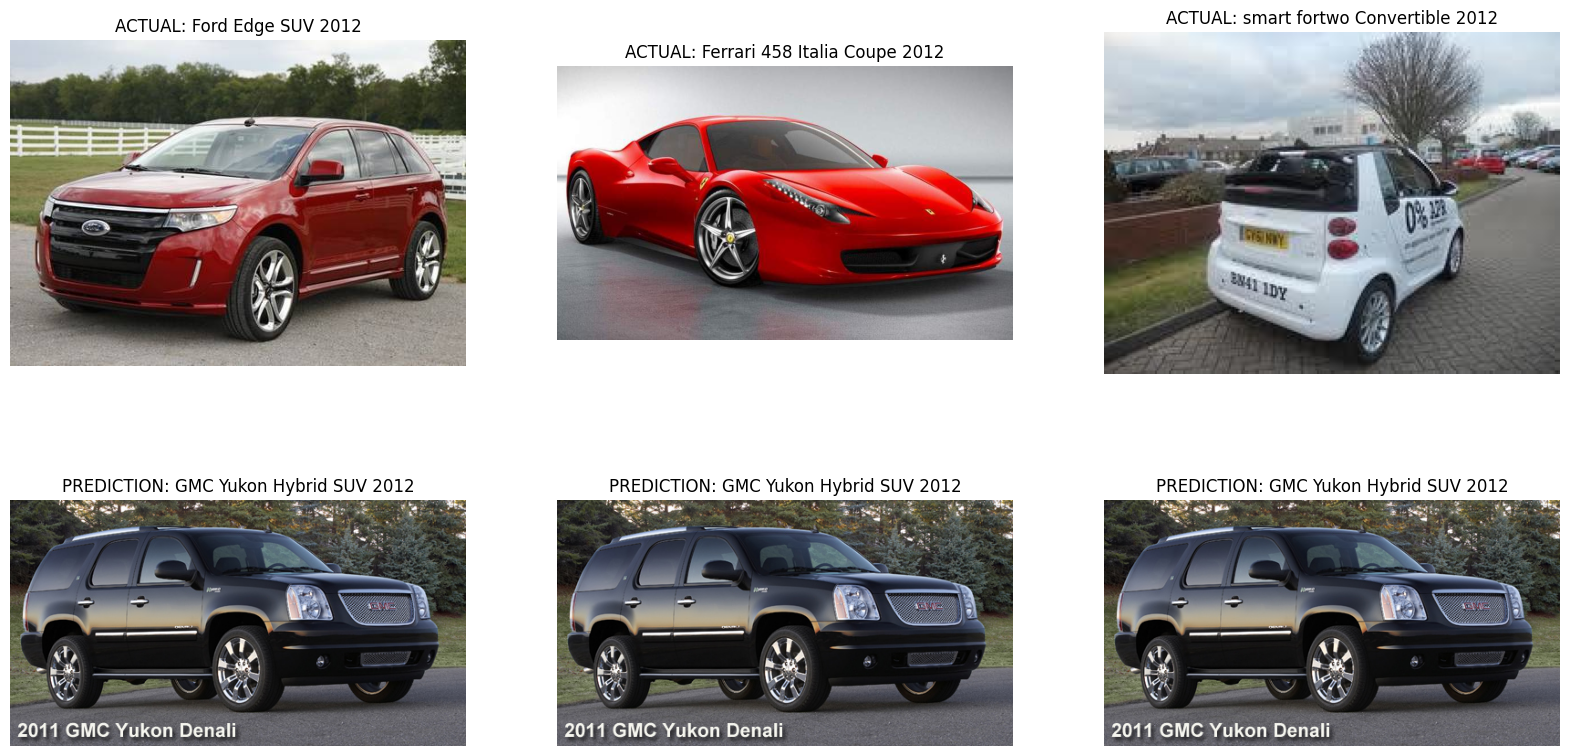

In [30]:
# Predictions
an_prediction = an.predict(test_gen_227)
plot_comparison(df_test=test, model_names=model_names, predicted_classes=an_prediction)

### VGG-16

<img src="../images/vgg16.jpg" style="width: 75%;"/>

**VGG-16** es una red neuronal convolucional profunda que fue creada por Karen Simonyan y Andrew Zisserman en 2014. El modelo VGG-16 se compone de 16 capas una capa de entrada, 13 capas convolucionales y 3 capas densas. La capa de entrada recibe una imagen de 224x224 píxeles. La entrada del modelo es una imagen RGB de 224x224x3. Hace uso de la función de activación **ReLU** en las capas convolucionales y de la función de activación **softmax** en la capa de salida.

In [17]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [18]:
# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
# Create VGG16 model
vgg16 = VGG16(input_shape=TARGET_SIZE_224 + (3,), num_classes=num_classes, see_summary=False)

In [17]:
# Train the model
vgg16_history = vgg16.train(train_generator=train_gen_224, validation_generator=val_gen_224, epochs=50, batch_size=BATCH_SIZE_16, verbose=1, patience=5)

Model not found
Training model...
Epoch 1/50
207/207 [==============================] - ETA: 0s - loss: 5.2931 - accuracy: 0.0068
Epoch 1: val_loss improved from inf to 5.27665, saving model to models/checkpoints/vgg16
INFO:tensorflow:Assets written to: models/checkpoints/vgg16/assets


INFO:tensorflow:Assets written to: models/checkpoints/vgg16/assets


207/207 [==============================] - 219s 967ms/step - loss: 5.2931 - accuracy: 0.0068 - val_loss: 5.2766 - val_accuracy: 0.0084
Epoch 2/50
207/207 [==============================] - ETA: 0s - loss: 5.2784 - accuracy: 0.0083
Epoch 2: val_loss improved from 5.27665 to 5.27557, saving model to models/checkpoints/vgg16
INFO:tensorflow:Assets written to: models/checkpoints/vgg16/assets


INFO:tensorflow:Assets written to: models/checkpoints/vgg16/assets


207/207 [==============================] - 163s 785ms/step - loss: 5.2784 - accuracy: 0.0083 - val_loss: 5.2756 - val_accuracy: 0.0084
Epoch 3/50
207/207 [==============================] - ETA: 0s - loss: 5.2775 - accuracy: 0.0083
Epoch 3: val_loss improved from 5.27557 to 5.27464, saving model to models/checkpoints/vgg16
INFO:tensorflow:Assets written to: models/checkpoints/vgg16/assets


INFO:tensorflow:Assets written to: models/checkpoints/vgg16/assets


207/207 [==============================] - 175s 843ms/step - loss: 5.2775 - accuracy: 0.0083 - val_loss: 5.2746 - val_accuracy: 0.0084
Epoch 4/50
207/207 [==============================] - ETA: 0s - loss: 5.2771 - accuracy: 0.0083
Epoch 4: val_loss improved from 5.27464 to 5.27392, saving model to models/checkpoints/vgg16
INFO:tensorflow:Assets written to: models/checkpoints/vgg16/assets


INFO:tensorflow:Assets written to: models/checkpoints/vgg16/assets


207/207 [==============================] - 181s 872ms/step - loss: 5.2771 - accuracy: 0.0083 - val_loss: 5.2739 - val_accuracy: 0.0084
Epoch 5/50
207/207 [==============================] - ETA: 0s - loss: 5.2765 - accuracy: 0.0083
Epoch 5: val_loss improved from 5.27392 to 5.27340, saving model to models/checkpoints/vgg16
INFO:tensorflow:Assets written to: models/checkpoints/vgg16/assets


INFO:tensorflow:Assets written to: models/checkpoints/vgg16/assets


207/207 [==============================] - 169s 814ms/step - loss: 5.2765 - accuracy: 0.0083 - val_loss: 5.2734 - val_accuracy: 0.0084
Epoch 6/50
207/207 [==============================] - ETA: 0s - loss: 5.2760 - accuracy: 0.0083
Epoch 6: val_loss improved from 5.27340 to 5.27295, saving model to models/checkpoints/vgg16
INFO:tensorflow:Assets written to: models/checkpoints/vgg16/assets


INFO:tensorflow:Assets written to: models/checkpoints/vgg16/assets


Restoring model weights from the end of the best epoch: 1.
207/207 [==============================] - 176s 848ms/step - loss: 5.2760 - accuracy: 0.0083 - val_loss: 5.2730 - val_accuracy: 0.0084
Epoch 6: early stopping
Model and history saved


In [ ]:
# Evaluate the model
vgg16_loss, vgg16_acc = vgg16.evaluate(test_gen_224)
plot_evaluation(history=vgg16_history)

In [ ]:
# Predictions
vgg16_prediction = vgg16.predict(test_gen_224)
plot_comparison(df_test=test, model_names=model_names, predicted_classes=vgg16_prediction)

### GoogLeNet y Inception


<img src="../images/googlenet.jpg" style="width: 75%;"/>

**GoogleNet** es una red neuronal convolucional profunda de 22 capas que fue desarrollada por investigadores de Google en 2014. GoogleNet ganó el primer lugar en el Desafío de reconocimiento visual a gran escala de ImageNet 2014 (ILSVRC14), una competencia internacional para resolver tareas de visión artificial como la clasificación de imágenes y la detección de objetos.

El uso de Inception es una característica distintiva de **GoogleNet**, que consiste en combinar diferentes bloques de convolución con diferentes tamaños y funciones para procesar una misma imagen. Estos bloques se llaman módulos **Inception** y se organizan en varias capas. Cada módulo Inception tiene un número variable de canales, que son las unidades básicas que transmiten información entre las capas. Algunos módulos **Inception** tienen más canales que otros, lo que permite capturar características a diferentes resoluciones.

**GoogleNet** utiliza **Inception** para aprovechar la capacidad computacional de las matrices densas, que son matrices con muchos elementos, y reducir el número de parámetros, que son los valores numéricos que determinan el comportamiento del modelo. Al agrupar las matrices dispersas en submatrices más densas, se puede mejorar el rendimiento informático sin aumentar demasiado la complejidad del modelo2.

In [14]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [15]:
# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
# Create GoogleLeNet model
gln = GoogleNet(input_shape=TARGET_SIZE_224 + (3,), num_classes=num_classes, see_summary=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 maxpool_1 (MaxPooling2D)    (None, 56, 56, 64)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 56, 56, 64)           4160      ['maxpool_1[0][0]']           
                                                                                              

In [17]:
# Train the model
gln_history = gln.train(train_generator=train_gen_224, validation_generator=val_gen_224, epochs=50, batch_size=32, verbose=1, patience=5)

Model not found
Training model...
Epoch 1/50


2023-12-14 00:27:16.964088: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


207/207 [==============================] - ETA: 0s - loss: 5.2805 - accuracy: 0.0061
Epoch 1: val_loss improved from inf to 5.27713, saving model to models/checkpoints/googlenet
INFO:tensorflow:Assets written to: models/checkpoints/googlenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/googlenet/assets


207/207 [==============================] - 230s 1s/step - loss: 5.2805 - accuracy: 0.0061 - val_loss: 5.2771 - val_accuracy: 0.0084
Epoch 2/50
207/207 [==============================] - ETA: 0s - loss: 5.2781 - accuracy: 0.0083
Epoch 2: val_loss improved from 5.27713 to 5.27615, saving model to models/checkpoints/googlenet
INFO:tensorflow:Assets written to: models/checkpoints/googlenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/googlenet/assets


207/207 [==============================] - 234s 1s/step - loss: 5.2781 - accuracy: 0.0083 - val_loss: 5.2761 - val_accuracy: 0.0084
Epoch 3/50
207/207 [==============================] - ETA: 0s - loss: 5.2776 - accuracy: 0.0083
Epoch 3: val_loss improved from 5.27615 to 5.27547, saving model to models/checkpoints/googlenet
INFO:tensorflow:Assets written to: models/checkpoints/googlenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/googlenet/assets


207/207 [==============================] - 220s 1s/step - loss: 5.2776 - accuracy: 0.0083 - val_loss: 5.2755 - val_accuracy: 0.0084
Epoch 4/50
207/207 [==============================] - ETA: 0s - loss: 5.2769 - accuracy: 0.0083
Epoch 4: val_loss improved from 5.27547 to 5.27446, saving model to models/checkpoints/googlenet
INFO:tensorflow:Assets written to: models/checkpoints/googlenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/googlenet/assets


207/207 [==============================] - 193s 932ms/step - loss: 5.2769 - accuracy: 0.0083 - val_loss: 5.2745 - val_accuracy: 0.0084
Epoch 5/50
207/207 [==============================] - ETA: 0s - loss: 5.2763 - accuracy: 0.0083
Epoch 5: val_loss improved from 5.27446 to 5.27374, saving model to models/checkpoints/googlenet
INFO:tensorflow:Assets written to: models/checkpoints/googlenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/googlenet/assets


207/207 [==============================] - 519s 3s/step - loss: 5.2763 - accuracy: 0.0083 - val_loss: 5.2737 - val_accuracy: 0.0084
Epoch 6/50
207/207 [==============================] - ETA: 0s - loss: 5.2760 - accuracy: 0.0083
Epoch 6: val_loss improved from 5.27374 to 5.27332, saving model to models/checkpoints/googlenet
INFO:tensorflow:Assets written to: models/checkpoints/googlenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/googlenet/assets


Restoring model weights from the end of the best epoch: 1.
207/207 [==============================] - 149s 721ms/step - loss: 5.2760 - accuracy: 0.0083 - val_loss: 5.2733 - val_accuracy: 0.0084
Epoch 6: early stopping
Model and history saved


252/252 [==============================] - 94s 371ms/step - loss: 5.2772 - accuracy: 0.0085
Loss: 5.28
Accuracy: 0.85%


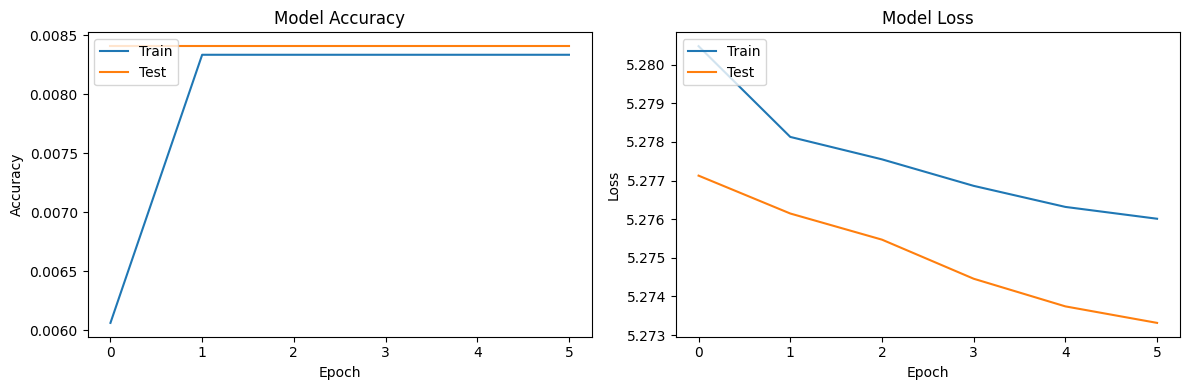

In [18]:
# Evaluate the model
gln_loss, gln_acc = gln.evaluate(test_gen_224)
plot_evaluation(history=gln_history)

252/252 [==============================] - 55s 217ms/step


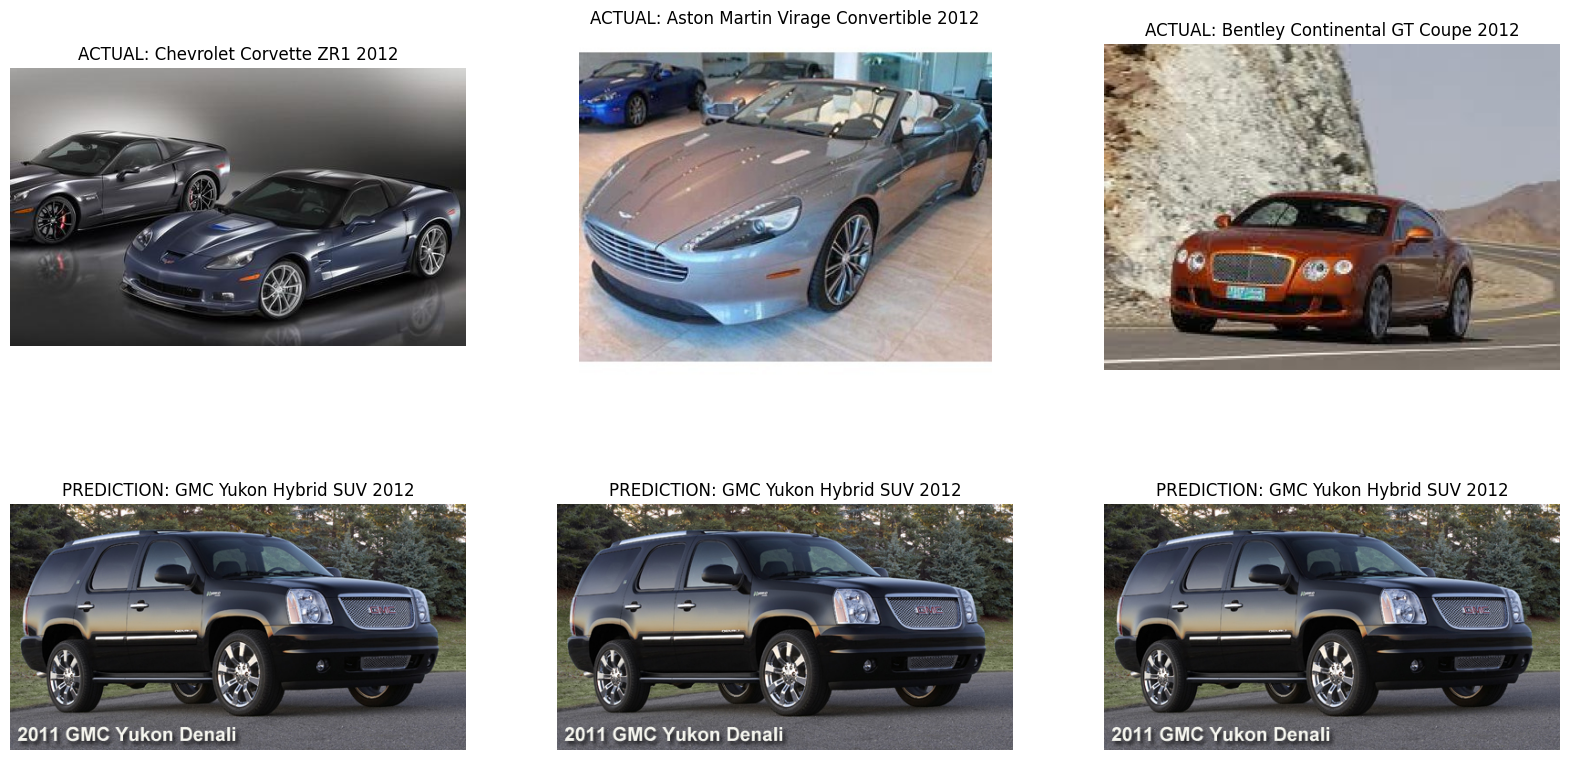

In [19]:
gln_prediction = gln.predict(test_gen_224)
plot_comparison(df_test=test, model_names=model_names, predicted_classes=gln_prediction)

### ResNet Model

ResNet es un modelo de aprendizaje profundo que usa conexiones saltas para resolver el problema del gradiente desvanecido/explotado. Fue propuesto en 2015 por investigadores de Microsoft Research como una forma de mejorar el rendimiento de las redes neuronales profundas. ResNet significa Red Residual, lo que significa que usa bloques residuales que añaden la entrada de una capa a su salida, creando una conexión saltada.

In [13]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [14]:
# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
# Create ResNet model
rn50 = ResNet(input_shape=TARGET_SIZE_224 + (3,), num_classes=num_classes, see_summary=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                             

In [16]:
# Train the model
rn50_history = rn50.train(train_generator=train_gen_224, validation_generator=val_gen_224, epochs=50, batch_size=BATCH_SIZE_8, patience=8)

Model loaded
History loaded


252/252 [==============================] - 70s 269ms/step - loss: 5.2746 - accuracy: 0.0085
Loss: 5.27
Accuracy: 0.85%


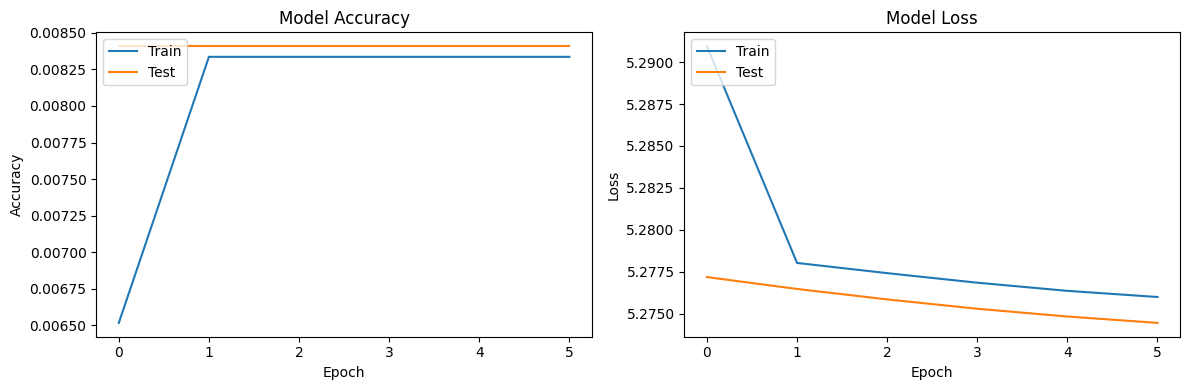

In [17]:
# Evaluate the model
rn50_loss, rn50_acc = rn50.evaluate(test_gen_224)
plot_evaluation(history=rn50_history)

252/252 [==============================] - 65s 259ms/step


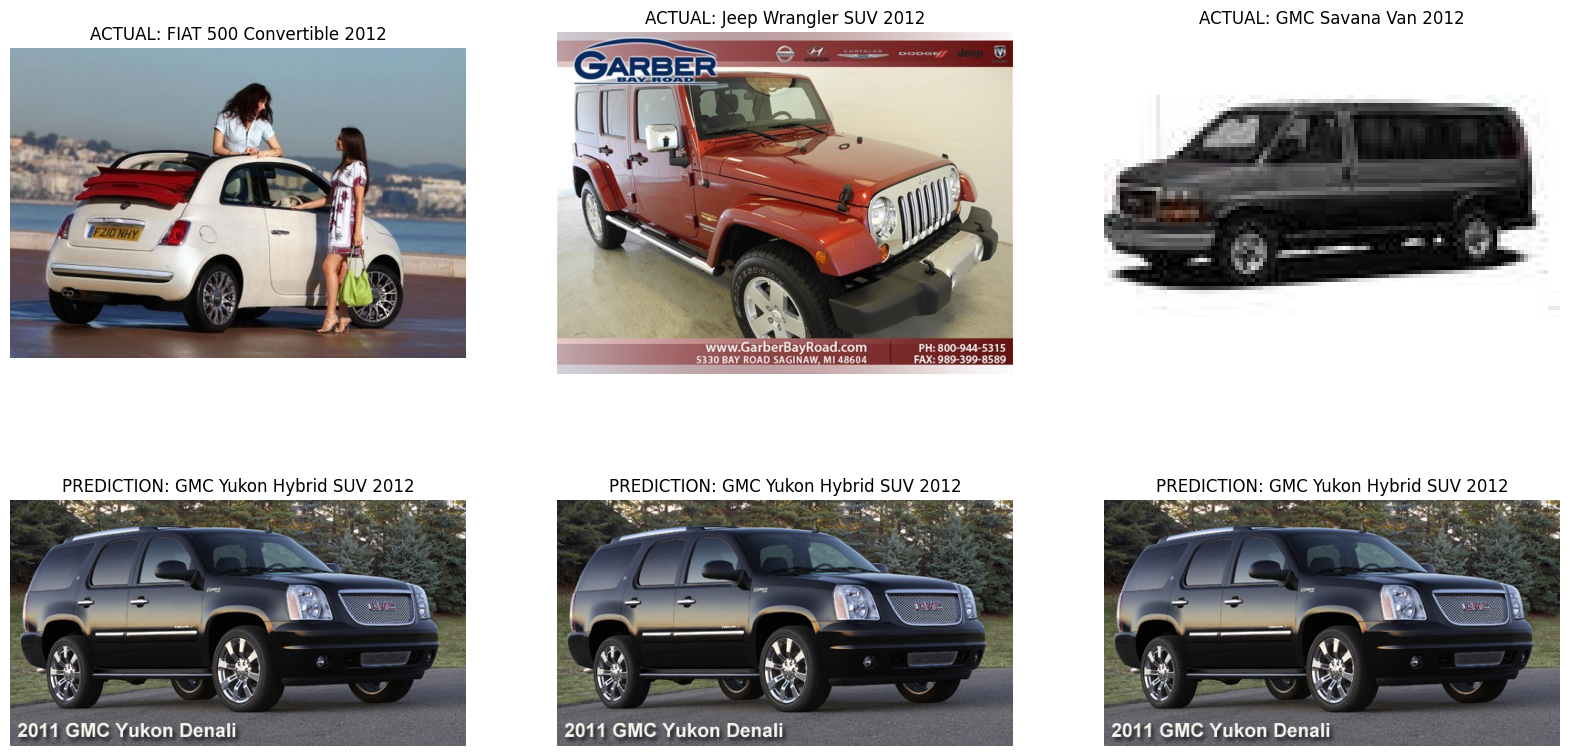

In [18]:
# Predictions
rn50_prediction = rn50.predict(test_gen_224)
plot_comparison(df_test=test, model_names=model_names, predicted_classes=rn50_prediction)